<a href="https://colab.research.google.com/github/PotatoSpudowski/CactiNet/blob/master/Building_EfficientNet_model_using_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim 

import torchvision
from torch.utils.data import DataLoader, Dataset
import torch.utils.data as utils
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import transforms
from torchsummary import summary

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

###Defining Layers

In [0]:
#Swish activation function
class Swish(nn.Module):
    """
    Activation function designed to kick ReLU's @$$
    """
    def forward(self, x):
        return x * torch.sigmoid(x)

In [0]:
class Conv2D_with_same_padding(nn.Conv2d):
    """
    Conv2d layer with padding implemented in a way such that size of 
    the input features and the output features remain same.
    """
    def __init__(self, in_ch, out_ch, kernel_size, stride=1, dilation=1, groups=1, bias=True, padding_mode="zeros"):
        super().__init__(in_ch, out_ch, kernel_size, stride, 0, dilation, groups, bias, padding_mode)

    def get_odd_padding(self, in_ch, weight, stride, dilation):
        filter_row =  (weight - 1) * dilation + 1
        out_rows = (in_ch + stride - 1) // stride
        padding = max(0, (out_rows - 1) * stride + filter_row - in_ch)
        padding_val= max(0, (out_rows - 1) * stride + (weight - 1) * dilation + 1 - in_ch)
        odd = (padding_val % 2 != 0)
        return padding_val, odd

    def forward(self, x):
        padding_row, row_odd = self.get_odd_padding(x.shape[2], self.weight.shape[2], self.stride[0], self.dilation[0])
        padding_collumn, collumn_odd = self.get_odd_padding(x.shape[3], self.weight.shape[3], self.stride[1], self.dilation[1])

        if row_odd or collumn_odd:
            x = F.pad(x, [0, int(collumn_odd), 0, int(row_odd)])
        
        return F.conv2d(x, self.weight, self.bias, self.stride,
                        padding = (padding_row // 2, padding_collumn //2),
                        dilation = self.dilation,
                        groups=self.groups)

class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.shape[0], -1)

class SqueezeExcitationModule(nn.Module):
    def __init__(self, in_ch, squeeze_ch):
        super().__init__()
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(in_ch, squeeze_ch, kernel_size=1, stride=1, padding=0, bias=True),
            Swish(),
            nn.Conv2d(squeeze_ch, in_ch, kernel_size=1, stride=1, padding=0, bias=True)
        )

    def forward(self, x):
        return x * torch.sigmoid(self.se(x))

class DropConnections(nn.Module):
    """
    Rndomly disables individual weights
    """
    def __init__(self, ratio):
        super().__init__()
        self.ratio = 1.0 - ratio

    def forward(self, x):
        if not self.training:
            return x

        ran_tensor = self.ratio
        ran_tens += torch.rand([x.shape[0], 1, 1, 1], dtype=torch.float, device=x.device)
        ran_tensor.requires_grad_(False)
        return x / self.ratio * ran_tensor.floor()

def Conv_BatchNorm_Activation(in_ch, out_ch, kernel_size, stride=1, groups=1, bias=True, eps=1e-3, momentum=0.01):
    return nn.Sequential(
        Conv2D_with_same_padding(in_ch, out_ch, kernel_size, stride, groups=groups, bias=bias),
        nn.BatchNorm2d(out_ch, eps, momentum),
        Swish()
    )

###Defining MBConv layer and MBConv Block

In [0]:
class MBConv(nn.Module):
    def __init__(self, in_ch, out_ch, expand, kernel_size, stride, skip, se_ratio, dc_ratio=0.2):
        super().__init__()
        mid = in_ch * expand
        if expand != 0:
            self.expand_conv = Conv_BatchNorm_Activation(in_ch, mid, kernel_size=1, bias = False)
        else:
            nn.Identity()

        self.depth_wise_conv = Conv_BatchNorm_Activation(mid, mid, kernel_size=kernel_size, stride=stride, groups=mid, bias=False)

        if se_ratio > 0:
            self.se = SqueezeExcitationModule(mid, int(in_ch * se_ratio)) 
        else:
            nn.Identity()

        self.project_conv = nn.Sequential(
            Conv2D_with_same_padding(mid, out_ch, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(out_ch, 1e-3, 0.01)
        )

        self.skip = skip and (stride == 1) and (in_ch == out_ch)

        self.dropconnect = nn.Identity()

    def forward(self, x):
        expand = self.expand_conv(x)
        x1 = self.depth_wise_conv(expand)
        x1 = self.se(x1)
        x1 = self.project_conv(x1)
        if self.skip:
            x1 = self.dropconnect(x1)
            x1 = x1 + x
        return x1

class MBBlock(nn.Module):
    def __init__(self, in_ch, out_ch, expand, kernel, stride, num_repeat, skip, se_ratio, drop_connect_ratio=0.2):
        super().__init__()
        layers = [
            MBConv(in_ch, out_ch, expand, kernel, stride, skip, se_ratio, drop_connect_ratio)
        ]

        for i in range(1, num_repeat):
            layers.append(MBConv(out_ch, out_ch, expand, kernel, 1, skip, se_ratio, drop_connect_ratio))
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return  self.layers(x)

##Building the CactiNet model
Which is btw totally based on the EfficientNet-b0 model with a few additional MBBlock and change in channel sizes.

In [0]:
class CactiNet(nn.Module):
    def __init__(self, width_coeff=1, depth_coeff=1, depth_div=8, min_depth=None, dropout_rate=0.2, drop_connect_rate=0.2, num_classes=1):
        super().__init__()
        min_depth = min_depth or depth_div

        def renew_ch(x):
            if not width_coeff:
                return x

            x *= width_coeff
            new_x = max(min_depth, int(x + depth_div / 2) // depth_div * depth_div)
            if new_x < 0.9 * x:
                new_x += depth_div
            return int(new_x)

        def renew_repeat(x):
            return int(math.ceil(x * depth_coeff))

        self.stem = Conv_BatchNorm_Activation(3, renew_ch(32), kernel_size=3, stride=2, bias=False)

        self.blocks = nn.Sequential(
            MBBlock(renew_ch(32), renew_ch(18), 1, 3, 1, renew_repeat(1), True, 0.25, drop_connect_rate),
            MBBlock(renew_ch(18), renew_ch(28), 6, 3, 2, renew_repeat(2), True, 0.25, drop_connect_rate),
            MBBlock(renew_ch(28), renew_ch(46), 6, 5, 2, renew_repeat(2), True, 0.25, drop_connect_rate),
            MBBlock(renew_ch(46), renew_ch(80), 6, 3, 2, renew_repeat(3), True, 0.25, drop_connect_rate),
            MBBlock(renew_ch(80), renew_ch(122), 6, 5, 1, renew_repeat(3), True, 0.25, drop_connect_rate),
            MBBlock(renew_ch(122), renew_ch(192), 6, 5, 2, renew_repeat(4), True, 0.25, drop_connect_rate),
            MBBlock(renew_ch(192), renew_ch(320), 6, 3, 1, renew_repeat(1), True, 0.25, drop_connect_rate)
        )

        self.head = nn.Sequential(
            *Conv_BatchNorm_Activation(renew_ch(320), renew_ch(1280), kernel_size=1, bias=False),
            nn.AdaptiveAvgPool2d(1),
            nn.Dropout2d(dropout_rate, True),
            Flatten(),
            nn.Linear(renew_ch(1280), num_classes)
        )

    def forward(self, inputs):
        stem = self.stem(inputs)
        x = self.blocks(stem)
        head = self.head(x)
        return head

In [0]:
model = CactiNet()

In [0]:
model = model.to('cuda')

In [89]:
summary(model, (3, 40, 40))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
Conv2D_with_same_padding-1           [-1, 32, 20, 20]             864
       BatchNorm2d-2           [-1, 32, 20, 20]              64
             Swish-3           [-1, 32, 20, 20]               0
Conv2D_with_same_padding-4           [-1, 32, 20, 20]           1,024
       BatchNorm2d-5           [-1, 32, 20, 20]              64
             Swish-6           [-1, 32, 20, 20]               0
Conv2D_with_same_padding-7           [-1, 32, 20, 20]             288
       BatchNorm2d-8           [-1, 32, 20, 20]              64
             Swish-9           [-1, 32, 20, 20]               0
AdaptiveAvgPool2d-10             [-1, 32, 1, 1]               0
           Conv2d-11              [-1, 8, 1, 1]             264
            Swish-12              [-1, 8, 1, 1]               0
           Conv2d-13             [-1, 32, 1, 1]             288
SqueezeExcitationModu

In [0]:
torch.save(model.state_dict(), './CactiNet.pb')

##Training CactiNet

In [0]:
from google.colab import files
# files.upload()
#Upload the kaggle.json file here

In [0]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

In [60]:
!kaggle competitions download -c aerial-cactus-identification

  0% 0.00/160k [00:00<?, ?B/s]
100% 160k/160k [00:00<00:00, 60.5MB/s]
  0% 0.00/4.20M [00:00<?, ?B/s]
100% 4.20M/4.20M [00:00<00:00, 69.5MB/s]
 47% 9.00M/19.2M [00:00<00:00, 52.7MB/s]
100% 19.2M/19.2M [00:00<00:00, 76.2MB/s]
  0% 0.00/667k [00:00<?, ?B/s]
100% 667k/667k [00:00<00:00, 210MB/s]


In [62]:
# !unzip train.zip
# !unzip test.zip
!ls

CactiNet.pb  sample_data	    test      train	 train.zip
kaggle.json  sample_submission.csv  test.zip  train.csv


In [0]:
train = './train'
test = './test'

train_labels =  pd.read_csv('./train.csv')

In [0]:
class Data(Dataset):
    def __init__(self, df, data_dir, transform):
        super().__init__()
        self.df = df
        self.data_dir = data_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        img_name = self.df.id[index]
        label = self.df.has_cactus[index]

        img_path = os.path.join(self.data_dir, img_name)
        img = mpimg.imread(img_path)
        img = self.transform(img)
        return img, label

In [0]:
data_transf = transforms.Compose([transforms.ToPILImage(), transforms.ToTensor()])
train_data = Data(df = train_labels, data_dir = train, transform = data_transf)
train_loader = DataLoader(dataset = train_data, batch_size = 64)

In [0]:
for param in model.parameters():
    param.requires_grad = True

In [0]:
optimizer = optim.Adam(model.parameters(), lr=0.0001)
loss_func = nn.BCELoss()

In [93]:
%%time
loss_log = []
val_loss_log = []
n_epochs = 10

for epoch in range(n_epochs):
    print('Epoch {}/{}'.format(epoch, n_epochs - 1))
    print('-' * 50)

    model.train()
    for step, (data, target) in enumerate(train_loader):
        data, target = data.cuda(), target.cuda()
        target = target.float()

        optimizer.zero_grad()
        output = model(data)

        m = nn.Sigmoid()
        loss = loss_func(m(output), target)
        loss.backward()

        optimizer.step()

        if step % 10 == 0:
            loss_log.append(loss.item())      

    print('Epoch: {} - Loss: {}'.format(epoch+1, loss.item()))

Epoch 0/9
--------------------------------------------------
Epoch: 1 - Loss: 0.23227491974830627
Epoch 1/9
--------------------------------------------------
Epoch: 2 - Loss: 0.043363459408283234
Epoch 2/9
--------------------------------------------------
Epoch: 3 - Loss: 0.02042786218225956
Epoch 3/9
--------------------------------------------------
Epoch: 4 - Loss: 0.009691665880382061
Epoch 4/9
--------------------------------------------------
Epoch: 5 - Loss: 0.0021468650083988905
Epoch 5/9
--------------------------------------------------


KeyboardInterrupt: ignored

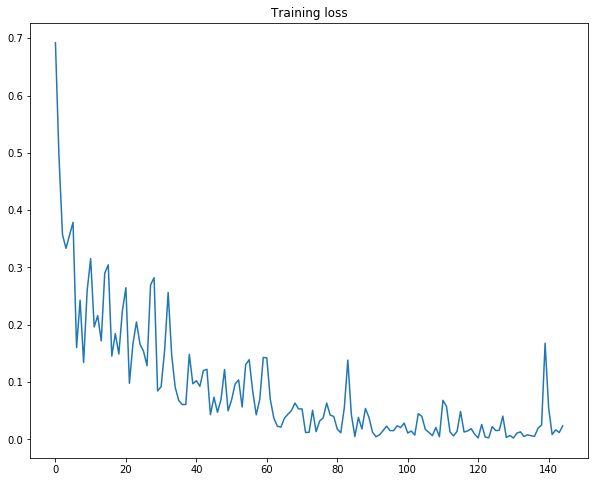

In [94]:
plt.figure(figsize=(10,8))
plt.title('Training loss')
plt.plot(loss_log)

In [0]:
submit = pd.read_csv('./sample_submission.csv')
test_data = Data(df = submit, data_dir = test, transform = data_transf) 
test_loader = DataLoader(dataset = test_data, shuffle=False)

In [96]:
%%time
predictions = []
model.eval()
for i, (data, _) in enumerate(test_loader):
    data = data.cuda()
    output = model(data)

    pred = torch.sigmoid(output)
    predictions.append(pred.item())

CPU times: user 48.9 s, sys: 124 ms, total: 49 s
Wall time: 49 s


In [0]:
submit['has_cactus'] = predictions
submit.to_csv('submission1.csv', index=False)

In [0]:
files.download('./submission1.csv')